HDBSCAN is a memory-efficient, hierarchical version of DBSCAN for large scale outliers.<br>
why we use?<br>
dbscan_cluster outputs are,
|cluster|cluster count|
|:----|:-----|
|-1|      399|
 |0|    49525|
 |1      | 20|
 |2|       12|
 |3      | 11|
 |4|       10|
 |5|       13|
 |6|       10|
 1) so we see cluster 0 with taxi count 49525. It is hugh count. HDBSCAN auto-tunes and finds multiple clusters better than DBSCAN with varying density. <br>
 2) In the previous dbscan, entire dataset is not used instead 50000 samples were used to generate 7 clusters. <br>


In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import sklearn
print(sklearn.__version__)
import pandas as pd

1.7.0


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# !pip install plotly
# !pip install nbformat --upgrade
# !pip install umap
# !pip uninstall umap
!pip install umap-learn

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 15.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 22.5 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 20.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.4/12.9 MB 29.6 MB/s eta 0:00:01
   ------- -------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load clean Data

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load data
df_cleaned = pd.read_csv("D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/cleaned_gps_dataset_20250624_0857.csv")
# Convert timestamp to numeric (e.g., seconds since epoch)

# df_cleaned['ts_num'] = pd.to_datetime(df_cleaned['timestamp']).astype(np.int64) // 10**9
df_cleaned['ts_num'] = (
    pd.to_datetime(df_cleaned['timestamp']) - pd.to_datetime(df_cleaned['timestamp']).min()
).dt.total_seconds()
df_cleaned.head(3)

,taxiid,timestamp,longitude,latitude,ts_num
0,3305,2008-02-02 13:34:25,116.46689,39.99742,221.0
1,3305,2008-02-02 13:39:23,116.46693,39.99744,519.0
2,3305,2008-02-02 13:39:26,116.46693,39.99744,522.0


# Implement HDBSCAN - Hierarchical Density-Based Spatial Clustering, ***unsupervised learning technique***<br>
1. We choose minimum cluster size based on following understanding <br>
1.a Fine-grained local hotspots (taxi stops, blocks)	100–300 <br>
1.b District-level cluster patterns	500–2000 <br>
1.c Very large, dominant movement zones	5000+ <br>
1.d Too small clusters → too many transitions → LSTM performance drops. <br>
Now, we choose min_cluster_size value based on our need to use the outlier output later to ***GMM & LSTN***. Both need <br> less noisy data. Fine-grained will provide too many clusters that may introduce noise. <br>
**So, our goal of using hdbscan is to preserve core shape of dense regions and only remote noise.** <br>
***Now we choose min_cluster_size = 1000***, because GMM needs clean, compact input → HDBSCAN filters noise & LSTM needs stable clusters over time → larger min_cluster_size avoids noisy flips. <br>
***min_cluster_size=10***, means A cluster must contain at least 10 points (i.e., data samples) to be considered a valid cluster.<br>


In [5]:
# Feature selection: latitude, longitude, and time
features = df_cleaned[['latitude', 'longitude', 'ts_num']]

# ✅ Yes — these 3 features are sufficient for spatiotemporal clustering.

In [6]:
# Standardize features to zero mean and unit variance
features_scaled = StandardScaler().fit_transform(features)
# ✅ Perfect — standardization ensures that latitude, longitude, and time contribute equally to the UMAP embedding.

In [ ]:
from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap
import umap
# 4. Apply UMAP to reduce to 2D
# umap_data = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(features_scaled)

umap_data = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(features_scaled)
# ✅ Good parameters:

# n_neighbors=30: captures local structure (e.g., taxis in a neighborhood/time window)

# min_dist=0.1: allows moderate separation of clusters in the 2D space

c:\LegacyApp\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
import hdbscan
from sklearn.preprocessing import MinMaxScaler

    # Step 1: Select features
features = df_cleaned[['latitude', 'longitude', 'ts_num']]

# Step 2: Normalize features, because ts_num (timestamp as number) might be on a totally different scale than 
# lat/lon, using MinMaxScaler() is important to avoid timestamp dominance.
features_scaled = MinMaxScaler().fit_transform(features)

# Step 3: Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=10)
df_cleaned['cluster'] = clusterer.fit_predict(features_scaled)

# Step 4: Print outlier count
print(f"Total outliers: {(df_cleaned['cluster'] == -1).sum()}")

c:\LegacyApp\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\LegacyApp\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Total outliers: 437448


Store outlier flag separately:

In [18]:
df_cleaned['is_outlier'] = (df_cleaned['cluster'] == -1).astype(int)

Check cluster distribution:

In [19]:
print(df_cleaned['cluster'].value_counts().sort_index())

cluster
-1      437448
 0        1528
 1        1169
 2         544
 3        2683
         ...  
 154      1341
 155       597
 156       535
 157      1114
 158      1401
Name: count, Length: 160, dtype: int64


Check number of valid clusters:

In [9]:
num_valid_clusters = df_cleaned['cluster'].nunique() - (1 if -1 in df_cleaned['cluster'].unique() else 0)
print(f"Number of valid clusters: {num_valid_clusters}")

Number of valid clusters: 84


Filter Only Valid Clusters (Exclude Outliers)

In [10]:
df_valid = df_cleaned[df_cleaned['cluster'] != -1].copy()
print(f"Filtered valid points: {len(df_valid)}")

Filtered valid points: 350150


Static Scatter Plot of Clusters

C:\Users\uif74417\AppData\Local\Temp\ipykernel_32616\1948326429.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_clusters))
C:\Users\uif74417\AppData\Local\Temp\ipykernel_32616\1948326429.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


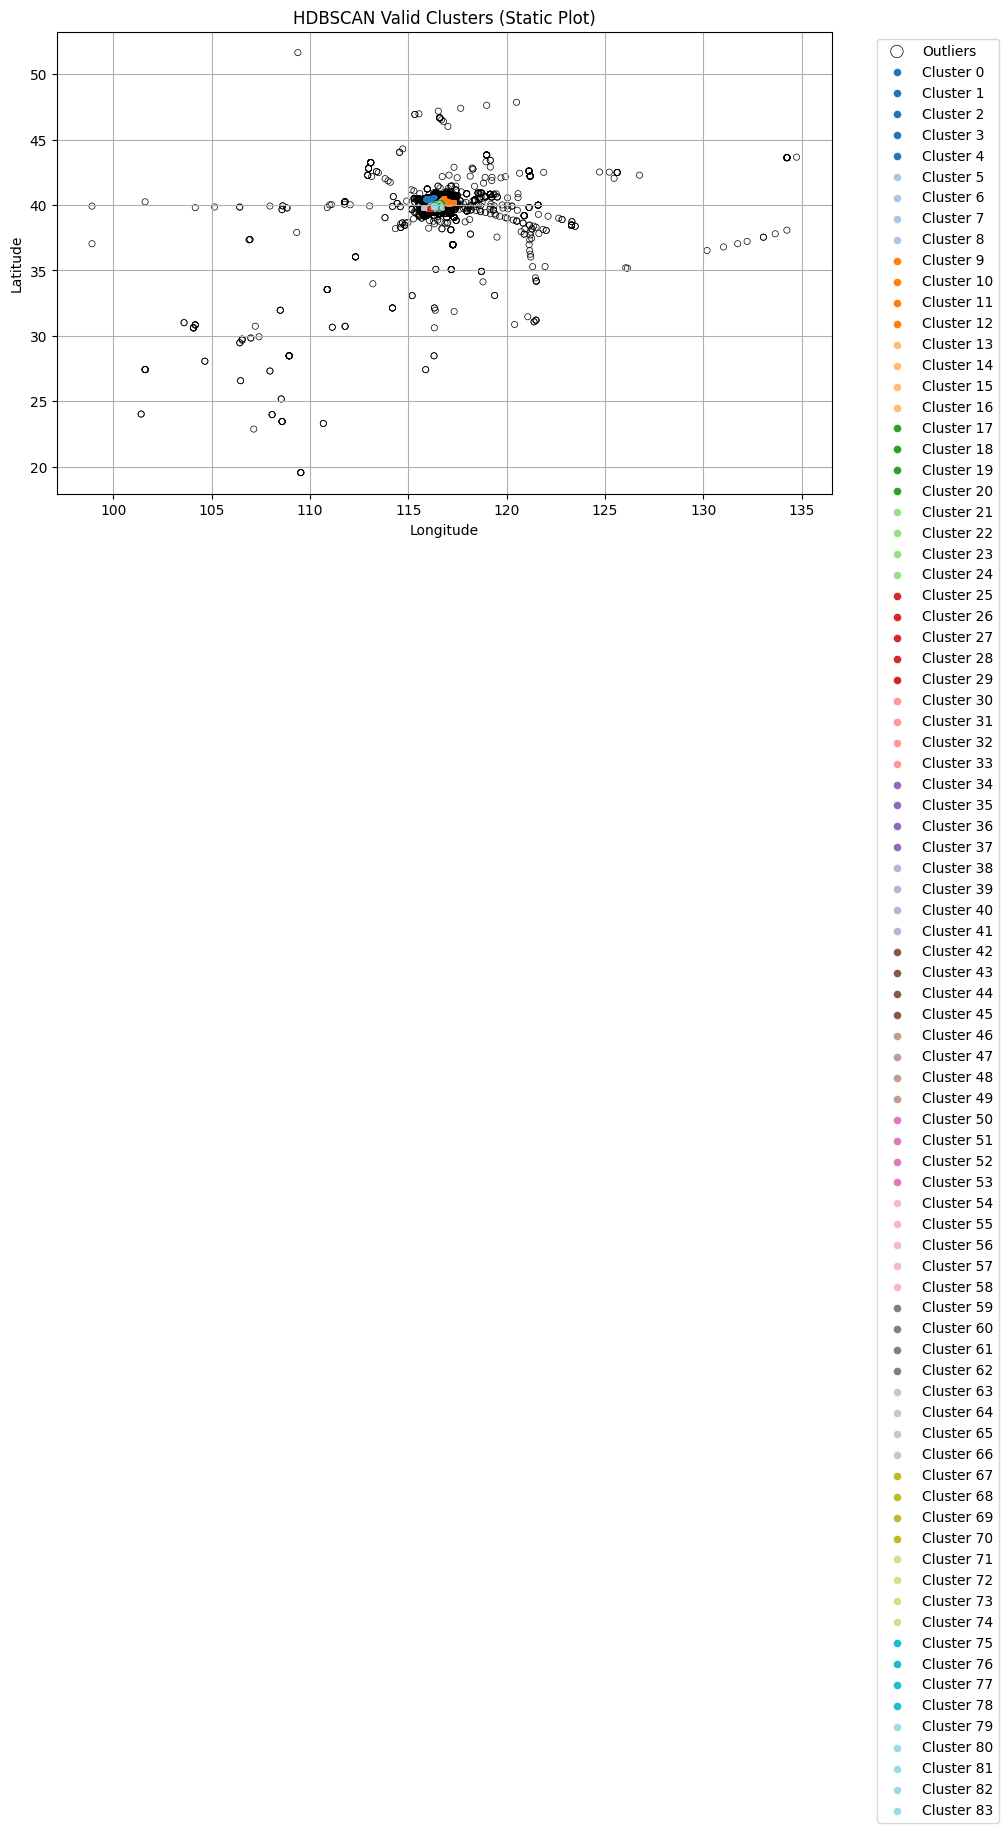

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))

# Get unique cluster labels (excluding -1)
unique_clusters = sorted(df_valid['cluster'].unique())
colors = cm.get_cmap('tab20', len(unique_clusters))

# Plot outliers as hollow black dots  
df_outliers = df_cleaned[df_cleaned['cluster'] == -1]  
plt.scatter(
    df_outliers['longitude'],
    df_outliers['latitude'],
    s=20,
    facecolors='none',
    edgecolors='black',
    linewidths=0.5,
    label='Outliers'
)

# Plot each cluster with a different color
for i, label in enumerate(unique_clusters):
    cluster_data = df_valid[df_valid['cluster'] == label]
    plt.scatter(
        cluster_data['longitude'],
        cluster_data['latitude'],
        s=5,
        color=colors(i),
        label=f"Cluster {label}"
    )



plt.title("HDBSCAN Valid Clusters (Static Plot)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Interactive Animation

In [ ]:
# import plotly.express as px
# import pandas as pd

# # Ensure timestamp is in datetime format
# df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# # Convert to string for animation frame (optional: group by hour for speed)
# df_cleaned['timestamp_str'] = df_cleaned['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

# # Replace -1 with 'Outlier' label
# df_cleaned['cluster_str'] = df_cleaned['cluster'].astype(str).replace('-1', 'Outlier')

# # Create animated interactive map using scatter_map
# fig = px.scatter_map(
#     df_cleaned,
#     lat='latitude',
#     lon='longitude',
#     color='cluster_str',
#     animation_frame='timestamp_str',
#     zoom=5,
#     height=600,
#     title="Animated HDBSCAN Clusters + Outliers",
#     center={"lat": 35.5, "lon": 103.5},  # Centered over China
# )

# fig.update_layout(
#     legend=dict(title="Cluster", x=1.05, y=1),
#     margin={"r": 0, "t": 40, "l": 0, "b": 0},
#     showlegend=True
# )

# fig.show()


df_cleaned.head(4)


,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier
0,3305,2008-02-02 13:34:25,116.46689,39.99742,1201959265,14,0
1,3305,2008-02-02 13:39:23,116.46693,39.99744,1201959563,14,0
2,3305,2008-02-02 13:39:26,116.46693,39.99744,1201959566,14,0
3,3305,2008-02-02 13:44:25,116.46690,39.99743,1201959865,14,0


Save HDBSCAN Output to CSV

In [12]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/hdbscan_cluster_outliers_{timestamp}.csv"
df_cleaned.to_csv(filename, index=False)